## Automatically find cuts using CKT

### Visualize the circuit

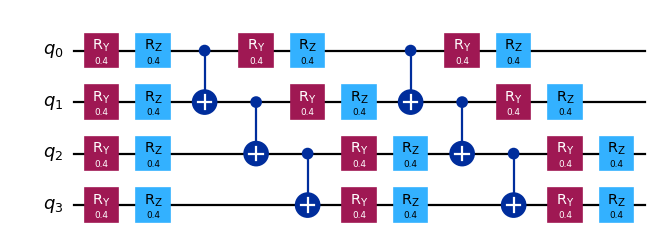

In [1]:
from qiskit.circuit.library import EfficientSU2

circ = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circ.assign_parameters([0.4] * len(circ.parameters), inplace=True)

circ.draw("mpl", scale=0.8, style="iqp")

### Perform cut finding

In [2]:
from circuit_knitting.cutting import find_cuts

# Specify settings for the cut-finding optimizer
optimization_settings = {"rand_seed": 12345}

# Specify the size and number of the QPUs available
qubits_per_qpu = 4
num_qpus = 2
device_constraints = {"qubits_per_QPU": qubits_per_qpu, "num_QPUs": num_qpus}

for num in range(num_qpus, 1, -1):
    for qpu_qubits in range(qubits_per_qpu, 1, -1):
        print(f'\n\n---------- {qpu_qubits} Qubits per QPU, {num} QPUs ----------')
        device_constraints = {"qubits_per_QPU": qpu_qubits, "num_QPUs": num}
        find_cuts(circ, optimization_settings, device_constraints)



---------- 4 Qubits per QPU, 2 QPUs ----------
 Gamma = 1.0 , Min_gamma_reached = True
[]
Subcircuits: AAAA 



---------- 3 Qubits per QPU, 2 QPUs ----------
 Gamma = 9.0 , Min_gamma_reached = True
[{'Cut action': 'CutTwoQubitGate', 'Cut Gate': [17, ['cx', 2, 3]]}, {'Cut action': 'CutTwoQubitGate', 'Cut Gate': [25, ['cx', 2, 3]]}]
Subcircuits: AAAB 



---------- 2 Qubits per QPU, 2 QPUs ----------
 Gamma = 9.0 , Min_gamma_reached = True
[{'Cut action': 'CutTwoQubitGate', 'Cut Gate': [9, ['cx', 1, 2]]}, {'Cut action': 'CutTwoQubitGate', 'Cut Gate': [20, ['cx', 1, 2]]}]
Subcircuits: AABB 



## Cut finding for 7 qubit circuit

### Visualize the circuit

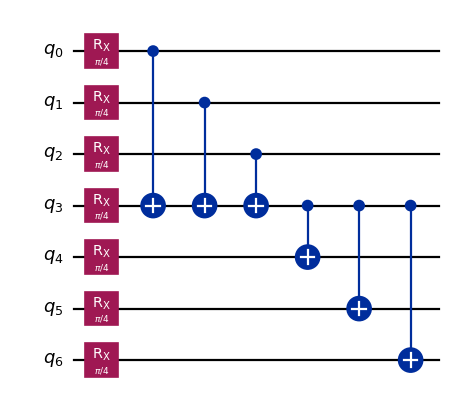

In [3]:
import numpy as np
from qiskit import QuantumCircuit

circ2 = QuantumCircuit(7)
for i in range(7):
    circ2.rx(np.pi / 4, i)
circ2.cx(0, 3)
circ2.cx(1, 3)
circ2.cx(2, 3)
circ2.cx(3, 4)
circ2.cx(3, 5)
circ2.cx(3, 6)

circ2.draw("mpl", scale=0.8, style="iqp")

### Perform cut finding

In [4]:
# Specify settings for the cut-finding optimizer
optimization_settings = {"rand_seed": 12345}

# Specify the size and number of the QPUs available
qubits_per_qpu = 7
num_qpus = 2

for num in range(num_qpus, 1, -1):
    for qpu_qubits in range(qubits_per_qpu, 1, -1):
        print(f'\n\n---------- {qpu_qubits} Qubits per QPU, {num} QPUs ----------')
        device_constraints = {"qubits_per_QPU": qpu_qubits, "num_QPUs": num}
        find_cuts(circ2, optimization_settings, device_constraints)



---------- 7 Qubits per QPU, 2 QPUs ----------
 Gamma = 1.0 , Min_gamma_reached = True
[]
Subcircuits: AAAAAAA 



---------- 6 Qubits per QPU, 2 QPUs ----------
 Gamma = 3.0 , Min_gamma_reached = True
[{'Cut action': 'CutTwoQubitGate', 'Cut Gate': [12, ['cx', 3, 6]]}]
Subcircuits: AAAAAAB 



---------- 5 Qubits per QPU, 2 QPUs ----------
 Gamma = 4.0 , Min_gamma_reached = True
[{'Cut action': 'CutLeftWire', 'Cut location': {'Gate': [11, ['cx', 3, 5]]}, 'Input wire': 1}]
Subcircuits: AAAABABB 



---------- 4 Qubits per QPU, 2 QPUs ----------
 Gamma = 4.0 , Min_gamma_reached = True
[{'Cut action': 'CutLeftWire', 'Cut location': {'Gate': [10, ['cx', 3, 4]]}, 'Input wire': 1}]
Subcircuits: AAAABBBB 



---------- 3 Qubits per QPU, 2 QPUs ----------
 Gamma = 16.0 , Min_gamma_reached = True
[{'Cut action': 'CutRightWire', 'Cut location': {'Gate': [9, ['cx', 2, 3]]}, 'Input wire': 2}, {'Cut action': 'CutLeftWire', 'Cut location': {'Gate': [11, ['cx', 3, 5]]}, 'Input wire': 1}]
Subcircuit